## Vocabulary Comparison

In [1]:
import csv
import json
import nltk
from tabulate import tabulate
from collections import Counter, defaultdict
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

In [2]:
def generate():
    return 0

def tag_compare(vocabs): #input scheme: [(vocab, vocab_name), (vocab, vocab_name)] - vocab (dict), vocab_name (str)
    #collection of all distinct tags
    tags = []
    for vocab in vocabs:
        for key in vocab[0].keys():
            if key not in tags:
                tags.append(key)
    #systematic comparison of all distinct tags with single vocabs
    vgl = {}
    for tag in tags:
        vgl[tag] = defaultdict(generate)
        sum = 0
        for vocab in vocabs:
            if tag in vocab[0].keys():
                vgl[tag][vocab[1]] = vgl[tag][vocab[1]] + 1
                sum = sum + 1
            else:
                vgl[tag][vocab[1]] = vgl[tag][vocab[1]]
        vgl[tag]["sum"] = sum
    return vgl

def tag_overview(vgl): #print overview - input: dict with count and sum per tag
    sums = []
    for key in vgl.keys():
        sums.append(vgl[key]["sum"])
    sum_counter = Counter(sums)
    for key in sorted(sum_counter.keys()):
        if key == 1:
            print("No overlaps:", sum_counter[key], "tags")
        else:
            print("Overlaps between", key, "vocabularies:", sum_counter[key], "tags")

def vocab_compare(vocab1, vocab2):
    zähler = 0
    for tag1 in vocab1.keys():
        for tag2 in vocab2.keys():
            if tag1 == tag2:
                zähler = zähler + 1
    return zähler

def vocab_matrix(vocabs):
    vocabs_dict = {}
    for vocab in vocabs:
        vocabs_dict[vocab[1]] = vocab[0]
    matrix = {}
    for entry in vocabs_dict.keys():
        for other in vocabs_dict.keys():
            titel = entry + "_" + other #e.g. acdh_dc
            count = vocab_compare(vocabs_dict[entry], vocabs_dict[other])
            matrix[titel] = count
    return matrix

#generate table: number of overlaps between compared vocabularies
def table_overlaps(vocabs, matrix):
    tabelle = []
    for vocab in vocabs:
        tabelle.append([vocab[1]])
    headers_tab = ["Vocabulary"]
    for element in tabelle:
        headers_tab = headers_tab + element
    zeile = 0
    for key in matrix.keys():
        tabelle[zeile].append(matrix[key])
        if len(tabelle[zeile]) == (len(vocabs) + 1): 
            zeile = zeile + 1
    print(tabulate(tabelle, headers = headers_tab))

#generate table: percentage of overlaps between compared vocabularies
def table_percentage(vocabs, matrix):
    tabelle = []
    for vocab in vocabs:
        tabelle.append([vocab[1]])
    headers_tab = ["Vocabulary"]
    for element in tabelle:
        headers_tab = headers_tab + element
    zeile = 0
    for key in matrix.keys():
        tabelle[zeile].append(matrix[key])
        if len(tabelle[zeile]) == (len(vocabs) + 1): 
            zeile = zeile + 1
    tabelle_proz = []
    for row in tabelle:
        nur_zahlen = [x if type(x)==int else 0 for x in row]
        maximum = max(nur_zahlen)
        row_new = [round((x*100/maximum), 2) if type(x)==int else x for x in row]
        tabelle_proz.append(row_new)
    print(tabulate(tabelle_proz, headers = headers_tab))

#generate heatmap of vocabularity similarity (= percentage of overlaps)
def heatmap(vocabs, matrix):
    tabelle = []
    for vocab in vocabs:
        tabelle.append([vocab[1]])
    headers_tab = ["Vocabulary"]
    for element in tabelle:
        headers_tab = headers_tab + element
    zeile = 0
    for key in matrix.keys():
        tabelle[zeile].append(matrix[key])
        if len(tabelle[zeile]) == (len(vocabs) + 1): 
            zeile = zeile + 1
    tabelle_proz = []
    for row in tabelle:
        nur_zahlen = [x if type(x)==int else 0 for x in row]
        maximum = max(nur_zahlen)
        row_new = [round((x*100/maximum), 2) if type(x)==int else x for x in row]
        tabelle_proz.append(row_new)
        
    #Zeilen- und Spaltenlabels definieren
    zeilen = []
    for vocab in vocabs:
        zeilen.append(vocab[1])
    spalten = zeilen

    #Daten definieren
    tabelle_proz_zahlen = [] #neue Liste von Listen exkl. Strings notwendig
    for zeile in tabelle_proz:
        nur_zahlen = [x for x in zeile if type(x)!=str]
        tabelle_proz_zahlen.append(nur_zahlen)
    daten = np.array(tabelle_proz_zahlen)

    #Initialisieren von Plots
    fig, heatmap = plt.subplots()
    im = heatmap.imshow(daten, cmap="YlGn")

    #Größe der Abbildung einstellen
    fig.set_figheight(8)
    fig.set_figwidth(10)

    #Labels hinzufügen
    heatmap.set_xticks(np.arange(len(spalten)), labels=spalten)
    heatmap.set_yticks(np.arange(len(zeilen)), labels=zeilen)

    #Spaltenbeschriftung nach oben
    heatmap.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    #Spaltenbeschriftung rotieren
    plt.setp(heatmap.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    #Loop über Daten --> Werte pro Heatmap-Kästchen anzeigen
    for i in range(len(zeilen)):
        for j in range(len(spalten)):
            text = heatmap.text(j, i, daten[i, j], ha="center", va="center", color="black")

    #Legende (Colorbar) hinzufügen
    legende = heatmap.figure.colorbar(im, ax=heatmap)
    legende.ax.set_ylabel(ylabel="Overlaps in percent", rotation=-90, va="bottom")

    #Titel hinzufügen
    heatmap.set_title("Similarity of vocabularies", fontsize=15)

    #Verbesserung des Layouts
    fig.tight_layout()

    plt.show()

#print tags that appear in at least x vocabularies (+ the respective vocabularies)
def tags_multiple(comp, x):
    for key in comp.keys():
        if comp[key]["sum"] >= x:
            vocabs_list = []
            for element in comp[key].keys():
                if element == "sum":
                    continue
                if comp[key][element] == 1:
                    vocabs_list.append(element)
            print(key, vocabs_list)

#print tags that appear in only one vocabulary (+ the respective vocabulary)
def tags_one(comp):
    for key in comp.keys():
        if comp[key]["sum"] == 1:
            for element in comp[key].keys():
                if element == "sum":
                    continue
                if comp[key][element] == 1:
                    print(key, "(" + element + ")")

## Data Import

In [3]:
#Import of ACDH-CH website (acdhch)

with open("acdhch_website.json", encoding = "utf-8") as datei:
    acdhch = json.load(datei)

#Import of ARCHE (all, hasAppliedMethod, hasCategory, hasSubject)

with open("arche.json", encoding = "utf-8") as datei:
    arche = json.load(datei)

with open("arche_hasAppliedMethod.json", encoding = "utf-8") as datei:
    arche_hasAppliedMethod = json.load(datei)

with open("arche_hasCategory.json", encoding = "utf-8") as datei:
    arche_hasCategory = json.load(datei)

with open("arche_hasSubject.json", encoding = "utf-8") as datei:
    arche_hasSubject = json.load(datei)

#Import of DARIAH-Campus (dc)
#Information included: count

with open("dariah_campus.json", encoding = "utf-8") as datei:
    dc = json.load(datei)

#Import of dha taxonomy

with open("dha_taxonomy.json", encoding = "utf-8") as datei:
    dha_taxonomy = json.load(datei)

#Import of dha website

with open("dha_website.json", encoding = "utf-8") as datei:
    dha_website = json.load(datei)

#Import of GAMS

with open("gams.json", encoding = "utf-8") as datei:
    gams = json.load(datei)

#Import of HowTo of the ACDH-CH (ht)
#Information included: description, count

with open("howto.json", encoding = "utf-8") as datei:
    ht = json.load(datei)

#Import of SSHOC

with open("SSHOC.json", encoding = "utf-8") as datei:
    sshoc = json.load(datei)

#Import of TaDiRAH Products

with open("tadirah_products.json", encoding = "utf-8") as datei:
    tadirah_prod = json.load(datei)

#Import of TaDiRAH Processes

with open("tadirah_processes.json", encoding = "utf-8") as datei:
    tadirah_proc = json.load(datei)

#Import of Zotero (KONDE)

with open("zotero_konde.json", encoding = "utf-8") as datei:
    zotero_konde = json.load(datei)

## Comparison and Analysis

### Vocabularies that can currently be compared:

- **ACDH-CH website** - https://www.oeaw.ac.at/acdh (tags from projects and tools) - English
- **ARCHE** - https://arche.acdh.oeaw.ac.at (hasAppliedMethod, hasSubject, hasCategory) - English/German
- **DARIAH Campus** - https://campus.dariah.eu/ (topics of resources) - English
- **dha taxonomy** - https://vocabs.acdh.oeaw.ac.at/dha_taxonomy - English
- **dha website** - https://digital-humanities.at/de/dha/projects (tags from projects) - English/German
- **GAMS** - https://gams.uni-graz.at/ (tags/keywords for filtering) - English and German (translations of tags given)
- **HowTo (ACDH-CH)** - https://howto.acdh.oeaw.ac.at (tags from posts) - English/German
- **SSHOC** - sshoc-keyword.ttl from https://github.com/SSHOC/vocabularies/tree/main/SSHOpenMarketplace/sshoc-keyword - English
- **TaDiRAH processes** - https://vocabs.dariah.eu/tadirah/en/ - English
- **TaDiRAH products** (modificated variant of original TaDiRAH taxonomy, work in progress in Graz) - English
- **Zotero (KONDE)** - https://www.zotero.org/groups/1332658/konde (manual and automatical tagging of research literature) - English/German/French/Spanish/Dutch etc.

### Abbreviations for choosing vocabularies

- ACDH-CH website --> acdhch
- ARCHE hasAppliedMethod --> arche_hasAppliedMethod
- ARCHE hasCategory --> arche_hasCategory
- ARCHE hasSubject --> arche_hasSubject
- ARCHE (all three categories together) --> arche
- Dariah Campus --> dc
- dha taxonomy --> dha_taxonomy
- dha website --> dha_website
- GAMS --> gams
- HowTo (ACDH-CH) --> ht
- SSHOC Keywords --> sshoc
- TaDiRAH processes --> tadirah_prod
- TaDiRAH products --> tadirah_proc
- Zotero (Konde) --> zotero_konde

### Choosing vocabularies for comparison

In [4]:
#first part of tuple: dictionary with vocab (possible choices cf. above/below)
#second part of tuple: name of choice for vocab

vocabs = [(acdhch, "ACDH-CH website"), 
            (arche, "ARCHE"), 
            (dc, "DARIAH Campus"), 
            (dha_taxonomy, "dha taxonomy"), 
            (dha_website, "dha website"),
            (gams, "gams"),
            (ht, "HowTo"),
            (sshoc, "SSHOC"),
            (tadirah_prod, "TaDiRAH Products"),
            (tadirah_proc, "TaDiRAH Processes"),
            (zotero_konde, "Zotero (KONDE)")
        ]

### Tag level

In [5]:
#tag level: generation of comparison file and first overview
comp = tag_compare(vocabs)
tag_overview(comp)

No overlaps: 2267 tags
Overlaps between 2 vocabularies: 254 tags
Overlaps between 3 vocabularies: 70 tags
Overlaps between 4 vocabularies: 26 tags
Overlaps between 5 vocabularies: 10 tags
Overlaps between 6 vocabularies: 5 tags
Overlaps between 7 vocabularies: 2 tags
Overlaps between 8 vocabularies: 1 tags


In [6]:
#print tags that appear in at least x vocabularies (+ the respective vocabularies)
tags_multiple(comp, 6)

annotation ['ACDH-CH website', 'ARCHE', 'dha taxonomy', 'dha website', 'SSHOC', 'TaDiRAH Products', 'Zotero (KONDE)']
linked open data ['ACDH-CH website', 'ARCHE', 'dha website', 'HowTo', 'SSHOC', 'TaDiRAH Products', 'TaDiRAH Processes']
metadata ['ACDH-CH website', 'DARIAH Campus', 'dha taxonomy', 'dha website', 'SSHOC', 'Zotero (KONDE)']
semantic web ['ACDH-CH website', 'DARIAH Campus', 'dha taxonomy', 'dha website', 'HowTo', 'Zotero (KONDE)']
tei ['ACDH-CH website', 'ARCHE', 'DARIAH Campus', 'dha taxonomy', 'dha website', 'HowTo', 'SSHOC', 'Zotero (KONDE)']
xml ['ARCHE', 'DARIAH Campus', 'dha taxonomy', 'HowTo', 'SSHOC', 'Zotero (KONDE)']
machine learning ['DARIAH Campus', 'dha website', 'SSHOC', 'TaDiRAH Products', 'TaDiRAH Processes', 'Zotero (KONDE)']
sentiment analysis ['dha taxonomy', 'dha website', 'SSHOC', 'TaDiRAH Products', 'TaDiRAH Processes', 'Zotero (KONDE)']


In [7]:
#print tags that appear in only one vocabulary (+ the respective vocabulary)
tags_one(comp)

aesthetics of music (ACDH-CH website)
austrian music studies (ACDH-CH website)
codicology (ACDH-CH website)
critical editions of music (ACDH-CH website)
cultural history (ACDH-CH website)
culture studies (ACDH-CH website)
dha conferences (ACDH-CH website)
digital editions (ACDH-CH website)
early modern studies (ACDH-CH website)
elexicography (ACDH-CH website)
exploration space (ACDH-CH website)
for interns (ACDH-CH website)
georeferenced data (ACDH-CH website)
history of musicology (ACDH-CH website)
history of scholarship (ACDH-CH website)
iconography of music (ACDH-CH website)
longterm projects (ACDH-CH website)
music philology (ACDH-CH website)
music theatre (ACDH-CH website)
musical sources (ACDH-CH website)
projects (ACDH-CH website)
text technology (ACDH-CH website)
training materials (ACDH-CH website)
visual culture (ACDH-CH website)
vocabularies (ACDH-CH website)
writings on music (ACDH-CH website)
fernerkundung (ARCHE)
pottery documentation. (ARCHE)
x-ray (ARCHE)
pottery docume

### Vocabulary Level

In [8]:
#vocabulary level: generation of comparison file and first overview
res = vocab_matrix(vocabs)
table_overlaps(vocabs, res)

Vocabulary           ACDH-CH website    ARCHE    DARIAH Campus    dha taxonomy    dha website    gams    HowTo    SSHOC    TaDiRAH Products    TaDiRAH Processes    Zotero (KONDE)
-----------------  -----------------  -------  ---------------  --------------  -------------  ------  -------  -------  ------------------  -------------------  ----------------
ACDH-CH website                   59        5                7              16             27       6        5       17                   2                    1                 7
ARCHE                              5      943                2              11             26       8        6       20                   6                    4                 6
DARIAH Campus                      7        2               49               8             11       0        6       11                   1                    1                 9
dha taxonomy                      16       11                8             120             85       6    

In [9]:
table_percentage(vocabs, res)

Vocabulary           ACDH-CH website    ARCHE    DARIAH Campus    dha taxonomy    dha website    gams    HowTo    SSHOC    TaDiRAH Products    TaDiRAH Processes    Zotero (KONDE)
-----------------  -----------------  -------  ---------------  --------------  -------------  ------  -------  -------  ------------------  -------------------  ----------------
ACDH-CH website               100        8.47            11.86           27.12          45.76   10.17     8.47    28.81                3.39                 1.69             11.86
ARCHE                           0.53   100                0.21            1.17           2.76    0.85     0.64     2.12                0.64                 0.42              0.64
DARIAH Campus                  14.29     4.08           100              16.33          22.45    0       12.24    22.45                2.04                 2.04             18.37
dha taxonomy                   13.33     9.17             6.67          100             70.83    5       

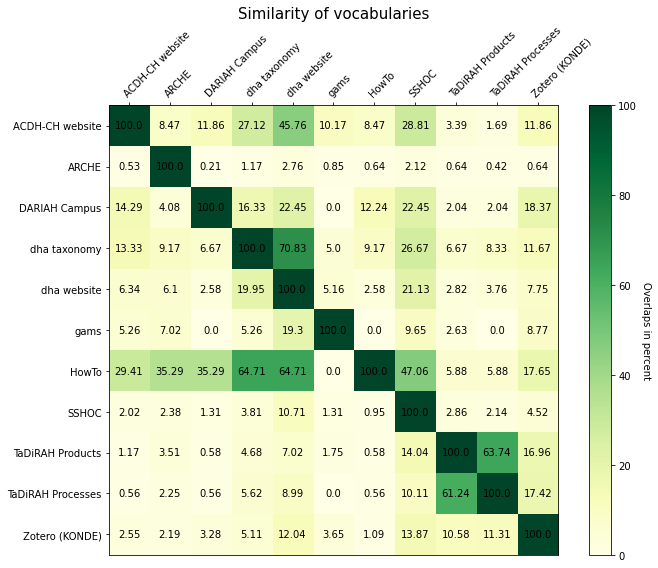

In [10]:
heatmap(vocabs, res)

### Identifying relevant DH tags and connections

In [11]:
#import of manual categorisation of ARCHE property "hasSubject" (done by Martin)

hasSubject_categorised = {}

with open("hasSubject_2022_07_15.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.split(";")
        subject = element[0].strip().lower()
        if subject == "\ufeffhasSubject":
            continue
        cause_irrelevance = element[2].strip()
        mapping = element[4].strip()
        hasSubject_categorised[subject] = {"cause_irrelevance": cause_irrelevance, "mapping": mapping}

In [12]:
#combining all collected tags from vocabularies with ARCHE-hasSubject-categorisation and saving them in a new csv-file

all_combined = {}

for key in comp.keys():
    vocabs_list = []
    for element in comp[key].keys():
        if element == "sum":
            continue
        if comp[key][element] == 1:
            vocabs_list.append(element)
    if key in hasSubject_categorised.keys():
        cause_irrelevance = hasSubject_categorised[key]["cause_irrelevance"]
        mapping = hasSubject_categorised[key]["mapping"]
    else:
        cause_irrelevance = ""
        mapping = ""
    all_combined[key] = {"vocabs_list": vocabs_list, "number_vocabs": len(vocabs_list), "cause_irrelevance": cause_irrelevance, "mapping": mapping}

with open("DH_tag_identification.csv", "w", newline = "", encoding = "utf-8") as datei:
    writer = csv.writer(datei, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["Tag", "Vocabularies", "Number of Vocabularies", "Cause for Irrelevance", "Mapping"])
    for key in all_combined.keys():
        writer.writerow(
            [key,
             ", ".join(all_combined[key]["vocabs_list"]),
             all_combined[key]["number_vocabs"],
             all_combined[key]["cause_irrelevance"],
             all_combined[key]["mapping"]])